In [1]:
import os
from urllib.request import urlretrieve

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer

import tensorflow_probability as tfp

In [2]:
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz', filename='fishing.npz')

d = np.load('fishing.npz')
X_train = d['Xt'] #"livebait","camper","persons","child"
X_test = d['Xte']
y_train = d['yt']
y_test = d['yte']

pd.DataFrame(X_train[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


In [3]:
def NLL(y_true, y_pred):
  return -y_pred.log_prob(y_true)

model = Sequential([
                    Dense(1, activation="exponential", input_shape=[4]),
                    tfp.layers.DistributionLambda(tfp.distributions.Poisson),
])

model.compile(optimizer='adam', loss=NLL)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 5         
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [4]:
history = model.fit(X_train, y_train, epochs=5000, verbose=0)

In [5]:
rmse_train = keras.metrics.RootMeanSquaredError()(y_train, model.predict(X_train)).numpy()
nll_train = model.evaluate(X_train, y_train, verbose=0)

print("Evaluation on train set")
print("RMSE: {}\nNLL: {}".format(rmse_train, nll_train))

Evaluation on train set
RMSE: 10.605659484863281
NLL: 3.335690498352051


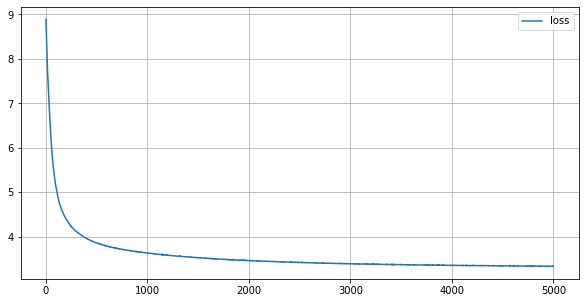

In [6]:
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.show()

In [7]:
weights = np.append(model.get_weights()[0], model.get_weights()[1])

print("Weights: {}".format(weights))

Weights: [ 0.859064    0.71315455  0.96870273 -1.6195402  -2.1654575 ]


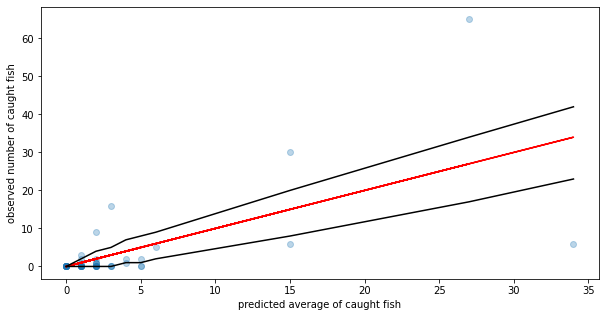

In [8]:
from scipy import stats

y_pred = model.predict(X_test)

p1 = stats.poisson.ppf(q=0.9, mu=np.sort(y_pred, axis=0))
p2 = stats.poisson.ppf(q=0.025, mu=np.sort(y_pred, axis=0))

fig, ax = plt.subplots(figsize=(10, 5))

plt.scatter(y_pred, y_test, alpha=0.3)

plt.plot(y_pred, y_pred, color="red")

plt.plot(np.sort(y_pred, axis=0), p1, color="black")
plt.plot(np.sort(y_pred, axis=0), p2, color="black")

plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')

plt.show()

In [9]:
rmse_test = keras.metrics.RootMeanSquaredError()(y_test, y_pred).numpy()
nll_test = model.evaluate(X_test, y_test, verbose=0)

print("Evaluation on test set")
print("RMSE: {}\nNLL: {}".format(rmse_test, nll_test))

Evaluation on test set
RMSE: 7.606575965881348
NLL: 2.785207509994507
